1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


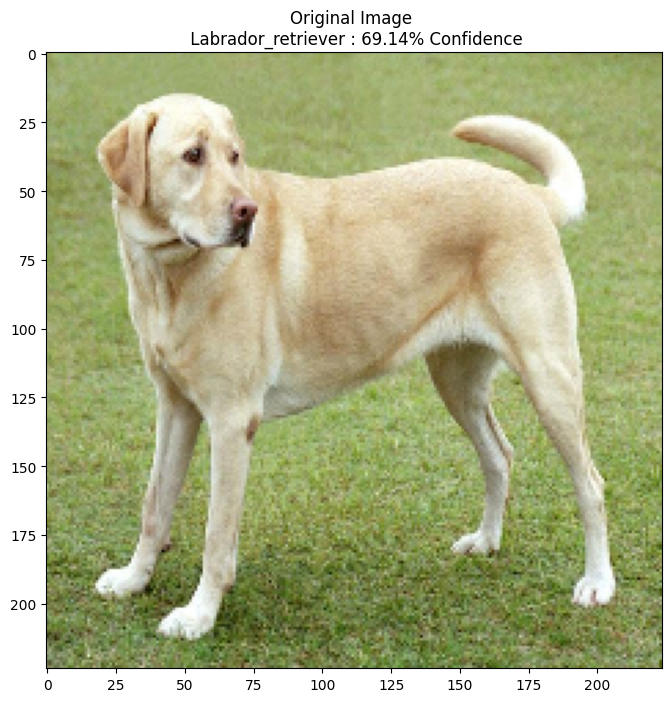

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


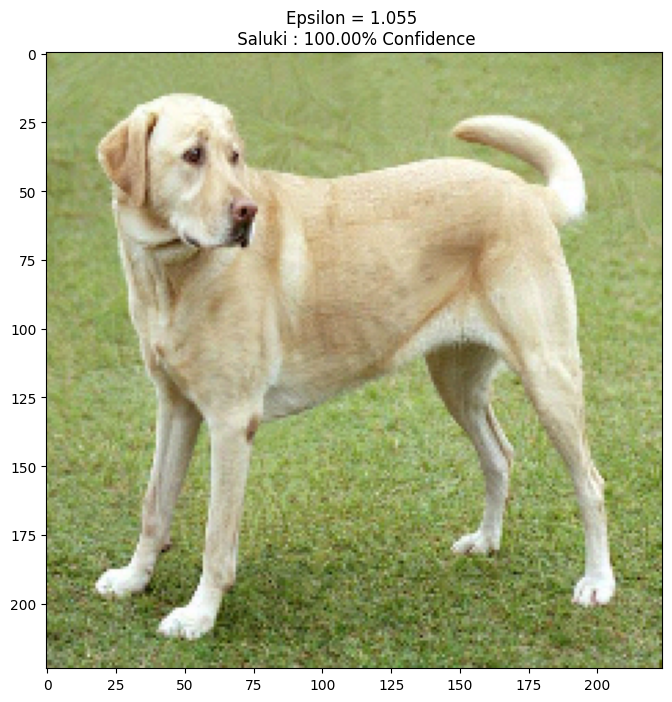

In [25]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Load EfficientNet model
pretrained_model = tf.keras.applications.EfficientNetB0(
    include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Set decode_predictions function for EfficientNet
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

# Preprocessing function
def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = image[None, ...]
    return image

# Function to decode predictions
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Load and preprocess image
image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

# Function to display images with descriptions
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0] / 255.0)  # Normalize to [0, 1] for display
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.show()
    
# Display original image
display_images(image, "Original Image")

# Adversarial pattern generation function
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_pgd_adversarial_pattern(input_image, input_label, epsilon=2.55, alpha=0.25, iterations=40):
    adversarial_image = tf.identity(input_image)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction = pretrained_model(adversarial_image)
            loss = loss_object(input_label, prediction)

        gradient = tape.gradient(loss, adversarial_image)
        signed_grad = tf.sign(gradient)
        adversarial_image = adversarial_image + alpha * signed_grad
        adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)  # Ensure the image stays within valid range
    return adversarial_image - input_image

# Generate adversarial pattern
prediction = pretrained_model.predict(image)
label = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
label = tf.reshape(label, (1, prediction.shape[-1]))

perturbations = create_pgd_adversarial_pattern(image, label)

# Display adversarial image with epsilon = 2.55
epsilon = 1.055
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, 0, 255)
display_images(adv_x, f'Epsilon = {epsilon}')

2024-05-23 18:41:36.371809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


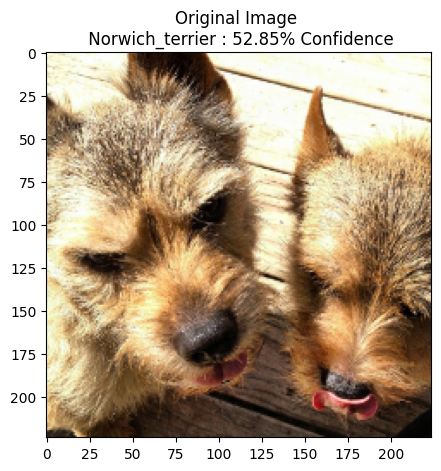

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


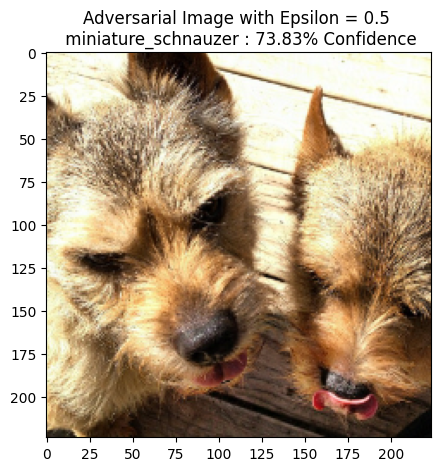

In [47]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

# Load EfficientNet model
pretrained_model = tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Set decode_predictions function for EfficientNet
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

# Preprocessing function
def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = image[None, ...]
    return image

# Function to decode predictions
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Load the ImageNet validation dataset
imagenet_validation_ds = tfds.load('imagenet_v2', split='test', as_supervised=True)

# Function to display images with descriptions
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0] / 255.0)  # Normalize to [0, 1] for display
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.show()

# Adversarial pattern generation function
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_pgd_adversarial_pattern(input_image, input_label, epsilon=2.55, alpha=0.15, iterations=40):
    adversarial_image = tf.identity(input_image)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction = pretrained_model(adversarial_image)
            loss = loss_object(input_label, prediction)

        gradient = tape.gradient(loss, adversarial_image)
        signed_grad = tf.sign(gradient)
        adversarial_image = adversarial_image + alpha * signed_grad
        adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)  # Ensure the image stays within valid range
    return adversarial_image - input_image

# Pick a random image from the dataset
def get_random_image_from_dataset(dataset):
    dataset_size = len(list(dataset))
    random_index = np.random.randint(0, dataset_size)
    for i, (image, label) in enumerate(dataset):
        if i == random_index:
            return image, label

# Main function to process and display images
def process_and_display_random_image(dataset):
    image, label = get_random_image_from_dataset(dataset)
    image = preprocess(image)
    image_probs = pretrained_model.predict(image)

    # Display original image
    display_images(image, "Original Image")

    # Generate adversarial pattern
    prediction = pretrained_model.predict(image)
    label_one_hot = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
    label_one_hot = tf.reshape(label_one_hot, (1, prediction.shape[-1]))

    perturbations = create_pgd_adversarial_pattern(image, label_one_hot)

    # Display adversarial image with epsilon = 2.55
    epsilon = 0.5
    adv_x = image + epsilon * perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 255)
    display_images(adv_x, f'Adversarial Image with Epsilon = {epsilon}')

# Run the main function to display a random image
process_and_display_random_image(imagenet_validation_ds)

2024-05-23 18:48:50.940100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


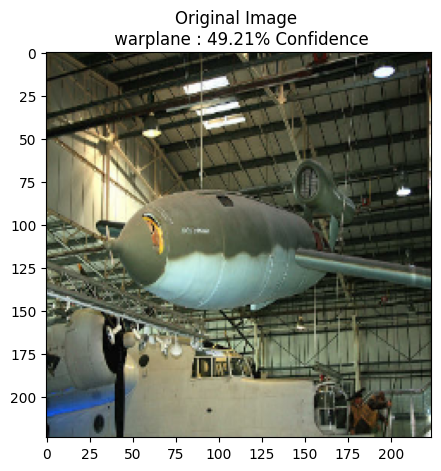

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


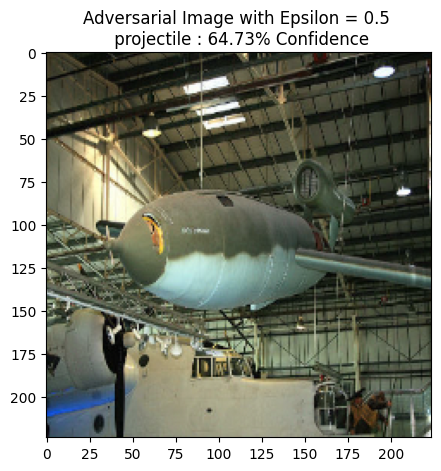

SSIM: 0.9967, PSNR: 46.86 dB


In [51]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False

# Load EfficientNet model
pretrained_model = tf.keras.applications.EfficientNetB0(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Set decode_predictions function for EfficientNet
decode_predictions = tf.keras.applications.efficientnet.decode_predictions

# Preprocessing function
def preprocess(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = image[None, ...]
    return image

# Function to decode predictions
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

# Load the ImageNet validation dataset
imagenet_validation_ds = tfds.load('imagenet_v2', split='test', as_supervised=True)

# Function to display images with descriptions
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0] / 255.0)  # Normalize to [0, 1] for display
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.show()

# Adversarial pattern generation function
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_pgd_adversarial_pattern(input_image, input_label, epsilon=2.55, alpha=0.15, iterations=40):
    adversarial_image = tf.identity(input_image)
    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            prediction = pretrained_model(adversarial_image)
            loss = loss_object(input_label, prediction)

        gradient = tape.gradient(loss, adversarial_image)
        signed_grad = tf.sign(gradient)
        adversarial_image = adversarial_image + alpha * signed_grad
        adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)  # Ensure the image stays within valid range
    return adversarial_image - input_image

# Pick a random image from the dataset
def get_random_image_from_dataset(dataset):
    dataset_size = len(list(dataset))
    random_index = np.random.randint(0, dataset_size)
    for i, (image, label) in enumerate(dataset):
        if i == random_index:
            return image, label

# Function to calculate SSIM and PSNR
def calculate_metrics(original_image, adversarial_image):
    original_image = tf.squeeze(original_image).numpy()
    adversarial_image = tf.squeeze(adversarial_image).numpy()
    
    # Normalize images to [0, 1] for SSIM and PSNR calculation
    original_image = original_image / 255.0
    adversarial_image = adversarial_image / 255.0

    ssim_value = ssim(original_image, adversarial_image, data_range=1.0, channel_axis=-1)
    psnr_value = psnr(original_image, adversarial_image, data_range=1.0)
    
    return ssim_value, psnr_value

# Main function to process and display images
def process_and_display_random_image(dataset):
    image, label = get_random_image_from_dataset(dataset)
    image = preprocess(image)
    image_probs = pretrained_model.predict(image)

    # Display original image
    display_images(image, "Original Image")

    # Generate adversarial pattern
    prediction = pretrained_model.predict(image)
    label_one_hot = tf.one_hot(tf.argmax(prediction[0]), prediction.shape[-1])
    label_one_hot = tf.reshape(label_one_hot, (1, prediction.shape[-1]))

    perturbations = create_pgd_adversarial_pattern(image, label_one_hot)

    # Display adversarial image with epsilon = 0.5
    epsilon = 0.5
    adv_x = image + epsilon * perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 255)
    display_images(adv_x, f'Adversarial Image with Epsilon = {epsilon}')

    # Calculate and display SSIM and PSNR
    ssim_value, psnr_value = calculate_metrics(image, adv_x)
    print(f'SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f} dB')

# Run the main function to display a random image
process_and_display_random_image(imagenet_validation_ds)